<a href="https://colab.research.google.com/github/maryamdarei/Manipulating-Images/blob/main/Normalization%20and%20border.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install adversarial-robustness-toolbox

In [4]:
!pip install grad_cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad_cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=29e669e7577ddf727bb585f8f9335e83bf18487472ea808f924bcf4bb2d8a4d2
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad_cam


In [2]:
import logging as log


import os


from datetime import datetime
import time 


import matplotlib.pyplot as plt
from matplotlib import ticker
from importlib.resources import path



import numpy as np


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision import transforms,datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter



from PIL import Image


from art.estimators.classification import PyTorchClassifier
from skimage.metrics import structural_similarity as ssim 

import warnings
warnings.filterwarnings('ignore') 


import sklearn.metrics as skmc 

In [3]:
from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget



In [4]:
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod

In [5]:
log.basicConfig(format="%(asctime)s %(message)s", level=log.INFO)
log.info("======= starting to log ========")
torch.cuda.empty_cache()

In [6]:
# Define relevant variables for the ML task
num_classes = 10
learning_rate = 0.001
num_epochs = 20  # actual 20 epochs
workers = 0
pin_memory = False
batch_size = 128

In [7]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    deviceid = torch.cuda.current_device()
    log.info(f"Gpu device {torch.cuda.get_device_name(deviceid)}")

In [8]:
modelname = "Res50"

In [9]:

# -------------------------------------------------------------------------------------------------------
# Load the data from image folder
# -------------------------------------------------------------------------------------------------------

data_dir = "/content/drive/MyDrive/Hebarium-Data-2019/Data/sample10"
train_dir = os.path.join(data_dir, "train")
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

# I changed the code for resize the image:
train_transforms = transforms.Compose(
    [
        
        transforms.Resize((277,277)),
        transforms.CenterCrop((230,240)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(0.5),
        transforms.ToTensor(),
        normalize_transform,
    ]
)

val_dir = os.path.join(data_dir, "validation")

val_transforms = transforms.Compose(
    [transforms.Resize((277,277)), transforms.CenterCrop((230,240)), transforms.ToTensor(), normalize_transform]
)


#transforms.CenterCrop((230,240)),

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


In [ ]:
foldername_to_class = {}
with open('/content/drive/MyDrive/Hebarium-Data-2019/Data/categories.txt', 'r') as file:
    for index, line in enumerate(file):
        if index == 0:
            continue
        else:
            data = line.split(',')
            foldername_to_class[str(int(data[0]))] = data[1].replace('\n', '')

print(foldername_to_class)



# creating a new dictionary
#my_dict ={"java":100, "python":112, "c":11}

 
# list out keys and values separately
key_list = list(foldername_to_class.keys())
val_list = list(foldername_to_class.values())
 
print(key_list)
print(val_list)
#print key with val 100
#position = val_list.index("Siphanthera cordata Pohl ex DC.")
print(key_list[val_list.index("Siphanthera cordata Pohl ex DC.")])
        

In [ ]:
# sort as value to fit the directory order to labels to be sure
print("Image to Folder Index", train_dataset.class_to_idx.items())
sorted_vals = dict(sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1]))

categories = []
for key in sorted_vals:
    print(key)
    classname = foldername_to_class[key]
    categories.append(classname)

log.info(f"Categories {categories}")

In [12]:
#load border images
# -------------------------------------------------------------------------------------------------------
# Initialise the data loaders
# -------------------------------------------------------------------------------------------------------

# ImageFile.LOAD_TRUNCATED_IMAGES = True # Use the data_checker.py and remove bad files instead of using this

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # IMPORTANT otherwise the data is not shuffled
    num_workers=workers,
    pin_memory=pin_memory,
    sampler=None,
)

test_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=pin_memory,
)


In [ ]:
#I added this line for running the model:
model = torchvision.models.resnet50()
model.to(device)


In [15]:
# initialize our optimizer and loss function
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
lossFn = nn.CrossEntropyLoss()

In [16]:

# -------------------------------------------------------------------------------------------------------
# Train the model
# -------------------------------------------------------------------------------------------------------

for images, labels in train_loader:
    log.info(f"Shape of X [N, C, H, W]: {images.shape}")
    log.info(f"Shape of y: {labels.shape} {labels.dtype}")
    # test one flow
    # pred = model(x)
    # loss = lossFn(pred, y)
    break
total_step = len(train_loader)
log.info(f"Total steps: {total_step}")

stepsize = total_step // 100
if stepsize < 10:
    stepsize = 10


In [17]:

# Write training matrics to Tensorboard
writer = SummaryWriter()

# loop over our epochs
for epoch in range(0, num_epochs):
    # set the model in training mode
    model.train()  # IMPORTANT otherwise the model is not in training mode
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainAccuracy = 0
    totalTrainAccuracy = 0
    valCorrect = 0

    # loop over the training set
    for i, (images, labels) in enumerate(train_loader):

        try:
            # Train in auto-mode with 16 bit mode
            # with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Train in normal mode
            with torch.autocast(device_type="cuda", dtype=torch.float32):
                # send the input to the device
                (images, labels) = (images.to(device), labels.to(device))
                # perform a forward pass and calculate the training loss
                outputs = model(images)
                # output is float16 because linear layers autocast to float16.
                # assert outputs.dtype is torch.float16 or 64

                loss = lossFn(outputs, labels)
                # zero out the gradients, perform the backpropagation step,
                # and update the weights
                writer.add_scalar("Loss/train", loss,  (epoch * total_step)+(i+1))
                opt.zero_grad()  # IMPORTANT otherwise the gradients of previous batches are not zeroed out
        except Exception as e:
            log.error(f"Exception in data processing- skip and continue = {e}")
        loss.backward()
        totalTrainLoss += loss
        opt.step()
        # Get the predicted values
        _, predicted = torch.max(outputs.data, 1)
        trainAccuracy = (predicted == labels).float().sum().item()
        trainAccuracy = 100 * trainAccuracy / labels.size(0)
        writer.add_scalar("Accuracy/train", trainAccuracy,(epoch * total_step)+(i+1))
        totalTrainAccuracy += trainAccuracy
        # if (i // stepsize) % 10 == 0:
        log.info(
            "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, i + 1, total_step, loss, trainAccuracy
            )
        )

    

    avgTrainLoss = totalTrainLoss / len(train_loader)
    avgAccuracy = totalTrainAccuracy / len(train_loader)
    log.info(
        "--->Epoch [{}/{}], Average Loss: {:.4f} Average Accuracy: {:.4f}".format(
            epoch + 1, num_epochs, avgTrainLoss, avgAccuracy
        )
    )

    print('Epoch [{}/{}], Loss: {:.4f}, TrainAccuracy: {:.4f} '.format(epoch+1, num_epochs, loss, trainAccuracy))

    # End Epoch loop
writer.flush()



Epoch [1/20], Loss: 2.1595, TrainAccuracy: 33.3333 
Epoch [2/20], Loss: 1.5281, TrainAccuracy: 53.6585 
Epoch [3/20], Loss: 1.3157, TrainAccuracy: 61.7886 
Epoch [4/20], Loss: 1.0582, TrainAccuracy: 67.4797 
Epoch [5/20], Loss: 0.9512, TrainAccuracy: 63.4146 
Epoch [6/20], Loss: 0.7823, TrainAccuracy: 77.2358 
Epoch [7/20], Loss: 0.7085, TrainAccuracy: 73.1707 
Epoch [8/20], Loss: 0.9874, TrainAccuracy: 71.5447 
Epoch [9/20], Loss: 0.6053, TrainAccuracy: 78.0488 
Epoch [10/20], Loss: 0.6198, TrainAccuracy: 79.6748 
Epoch [11/20], Loss: 0.3943, TrainAccuracy: 88.6179 
Epoch [12/20], Loss: 0.3178, TrainAccuracy: 88.6179 
Epoch [13/20], Loss: 0.3440, TrainAccuracy: 86.1789 
Epoch [14/20], Loss: 0.3259, TrainAccuracy: 92.6829 
Epoch [15/20], Loss: 0.2935, TrainAccuracy: 91.8699 
Epoch [16/20], Loss: 0.2996, TrainAccuracy: 90.2439 
Epoch [17/20], Loss: 0.2847, TrainAccuracy: 91.8699 
Epoch [18/20], Loss: 0.2111, TrainAccuracy: 90.2439 
Epoch [19/20], Loss: 0.1854, TrainAccuracy: 93.4959 
Ep

In [18]:
#Test with Border
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        

    print('Accuracy of the network on the {} validation images: {} %'.format(19, 100 * correct / total))
    # if labels[i]=!predicted[i]:
    #   print(*)
    print(labels)
    print(predicted)
  

Accuracy of the network on the 19 validation images: 67.34693877551021 %
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9,
        9], device='cuda:0')
tensor([1, 1, 6, 1, 1, 7, 1, 8, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 2,
        4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 4, 7, 2, 8, 6, 9,
        5], device='cuda:0')


##Bordeeless section training and testing

In [19]:
#load brderless images, training and testing
# -------------------------------------------------------------------------------------------------------
# Load the data from image folder
# -------------------------------------------------------------------------------------------------------

data_dir = "/content/drive/MyDrive/Hebarium-Data-2019/Data/SampleBorder10"
train_dir = os.path.join(data_dir, "train")
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

# I changed the code for resize the image:
train_transforms2 = transforms.Compose(
    [
        
        transforms.Resize((277,277)),
        transforms.CenterCrop((230,240)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(0.5),
        transforms.ToTensor(),
        normalize_transform,
    ]
)

val_dir = os.path.join(data_dir, "validation")

val_transforms2 = transforms.Compose(
    [transforms.Resize((277,277)), transforms.CenterCrop((230,240)), transforms.ToTensor(), normalize_transform]
)


#transforms.CenterCrop((230,240)),

train_dataset2 = torchvision.datasets.ImageFolder(train_dir, train_transforms2)
val_dataset2 = torchvision.datasets.ImageFolder(val_dir, val_transforms2)


In [20]:
#load borderless images
# -------------------------------------------------------------------------------------------------------
# Initialise the data loaders
# -------------------------------------------------------------------------------------------------------

# ImageFile.LOAD_TRUNCATED_IMAGES = True # Use the data_checker.py and remove bad files instead of using this

train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=batch_size,
    shuffle=True,  # IMPORTANT otherwise the data is not shuffled
    num_workers=workers,
    pin_memory=pin_memory,
    sampler=None,
)

test_loader2 = torch.utils.data.DataLoader(
    val_dataset2,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=pin_memory,
)


In [21]:

# -------------------------------------------------------------------------------------------------------
# Train the model
# -------------------------------------------------------------------------------------------------------

for images, labels in train_loader2:
    log.info(f"Shape of X [N, C, H, W]: {images.shape}")
    log.info(f"Shape of y: {labels.shape} {labels.dtype}")
    # test one flow
    # pred = model(x)
    # loss = lossFn(pred, y)
    break
total_step = len(train_loader2)
log.info(f"Total steps: {total_step}")

stepsize = total_step // 100
if stepsize < 10:
    stepsize = 10


In [22]:

# Write training matrics to Tensorboard
writer = SummaryWriter()

# loop over our epochs
for epoch in range(0, num_epochs):
    # set the model in training mode
    model.train()  # IMPORTANT otherwise the model is not in training mode
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainAccuracy = 0
    totalTrainAccuracy = 0
    valCorrect = 0

    # loop over the training set
    for i, (images, labels) in enumerate(train_loader2):

        try:
            # Train in auto-mode with 16 bit mode
            # with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Train in normal mode
            with torch.autocast(device_type="cuda", dtype=torch.float32):
                # send the input to the device
                (images, labels) = (images.to(device), labels.to(device))
                # perform a forward pass and calculate the training loss
                outputs = model(images)
                # output is float16 because linear layers autocast to float16.
                # assert outputs.dtype is torch.float16 or 64

                loss = lossFn(outputs, labels)
                # zero out the gradients, perform the backpropagation step,
                # and update the weights
                writer.add_scalar("Loss/train", loss,  (epoch * total_step)+(i+1))
                opt.zero_grad()  # IMPORTANT otherwise the gradients of previous batches are not zeroed out
        except Exception as e:
            log.error(f"Exception in data processing- skip and continue = {e}")
        loss.backward()
        totalTrainLoss += loss
        opt.step()
        # Get the predicted values
        _, predicted = torch.max(outputs.data, 1)
        trainAccuracy = (predicted == labels).float().sum().item()
        trainAccuracy = 100 * trainAccuracy / labels.size(0)
        writer.add_scalar("Accuracy/train", trainAccuracy,(epoch * total_step)+(i+1))
        totalTrainAccuracy += trainAccuracy
        # if (i // stepsize) % 10 == 0:
        log.info(
            "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, i + 1, total_step, loss, trainAccuracy
            )
        )

    

    avgTrainLoss = totalTrainLoss / len(train_loader2)
    avgAccuracy = totalTrainAccuracy / len(train_loader2)
    log.info(
        "--->Epoch [{}/{}], Average Loss: {:.4f} Average Accuracy: {:.4f}".format(
            epoch + 1, num_epochs, avgTrainLoss, avgAccuracy
        )
    )

    print('Epoch [{}/{}], Loss: {:.4f}, TrainAccuracy: {:.4f} '.format(epoch+1, num_epochs, loss, trainAccuracy))

    # End Epoch loop
writer.flush()



Epoch [1/20], Loss: 0.2797, TrainAccuracy: 91.5966 
Epoch [2/20], Loss: 0.2078, TrainAccuracy: 93.2773 
Epoch [3/20], Loss: 0.0699, TrainAccuracy: 98.3193 
Epoch [4/20], Loss: 0.3068, TrainAccuracy: 90.7563 
Epoch [5/20], Loss: 0.3419, TrainAccuracy: 93.2773 
Epoch [6/20], Loss: 0.0908, TrainAccuracy: 95.7983 
Epoch [7/20], Loss: 0.2337, TrainAccuracy: 91.5966 
Epoch [8/20], Loss: 0.2553, TrainAccuracy: 89.0756 
Epoch [9/20], Loss: 0.0428, TrainAccuracy: 99.1597 
Epoch [10/20], Loss: 0.2537, TrainAccuracy: 97.4790 
Epoch [11/20], Loss: 0.1068, TrainAccuracy: 95.7983 
Epoch [12/20], Loss: 0.0476, TrainAccuracy: 99.1597 
Epoch [13/20], Loss: 0.0168, TrainAccuracy: 100.0000 
Epoch [14/20], Loss: 0.1389, TrainAccuracy: 92.4370 
Epoch [15/20], Loss: 0.1003, TrainAccuracy: 97.4790 
Epoch [16/20], Loss: 0.0749, TrainAccuracy: 98.3193 
Epoch [17/20], Loss: 0.0294, TrainAccuracy: 99.1597 
Epoch [18/20], Loss: 0.0283, TrainAccuracy: 100.0000 
Epoch [19/20], Loss: 0.0387, TrainAccuracy: 99.1597 


In [25]:
#Test with Border
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader2:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        

    print('Accuracy of the network on the {} validation images: {} %'.format(19, 100 * correct / total))
    # if labels[i]=!predicted[i]:
    #   print(*)
    print(labels)
    print(predicted)
  

Accuracy of the network on the 19 validation images: 63.265306122448976 %
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9,
        9], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 7, 8, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 4, 1, 1, 4,
        4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 5, 5, 5, 6, 6, 1, 1, 6, 4, 1, 4, 8, 8, 6,
        8], device='cuda:0')


# Analyse Model:


In [21]:
model = model.eval()

In [22]:
#Testing without Border and eval mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} validation images: {} %'.format(19, 100 * correct / total))
    print(labels)
    print(predicted)

Accuracy of the network on the 19 validation images: 71.42857142857143 %
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9,
        9], device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
        4, 4, 1, 7, 4, 1, 4, 9, 4, 4, 5, 5, 5, 6, 6, 1, 6, 6, 4, 7, 1, 8, 8, 6,
        5], device='cuda:0')


In [23]:

def flatten_model(modules):
    def flatten_list(_2d_list):
        flat_list = []
        # Iterate through the outer list
        for element in _2d_list:
            if type(element) is list:
                # If the element is of type list, iterate through the sublist
                for item in element:
                    flat_list.append(item)
            else:
                flat_list.append(element)
        return flat_list

    ret = []
    try:
        for _, n in modules:
            ret.append(loopthrough(n))
    except:
        try:
            if str(modules._modules.items()) == "odict_items([])":
                ret.append(modules)
            else:
                for _, n in modules._modules.items():
                    ret.append(loopthrough(n))
        except:
            ret.append(modules)
    return flatten_list(ret)

In [ ]:
# Set the target for the CAM layer; Add all the layers in the model
target_layers =[]
module_list =[module for module in model.modules()]


flatted_list= flatten_model(module_list)


print("------------------------")
for count, value in enumerate(flatted_list):
    
    if isinstance(value, (nn.Conv2d,nn.AvgPool2d,nn.BatchNorm2d)):
    #if isinstance(value, (nn.Conv2d)):
        print(count, value)
        target_layers.append(value)

print("------------------------")


In [25]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
gradvariantname = "GradCAM_"


real class name:  Miconia approximata Gamba & Almeda
image 00000.jpg Detecting for class Leandra nianga (DC.) Cogn. by model Res50
-
Leandra nianga (DC.) Cogn. 0.5036107301712036
Miconia ibaguensis (Bonpl.) Triana 0.43598759174346924
--------------------------------


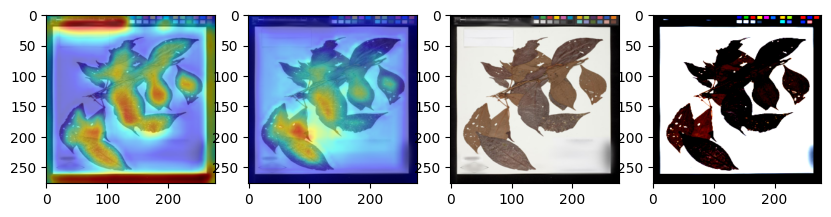

real class name:  Miconia approximata Gamba & Almeda
image 00001.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.8109182715415955
Leandra nianga (DC.) Cogn. 0.1821039915084839
--------------------------------


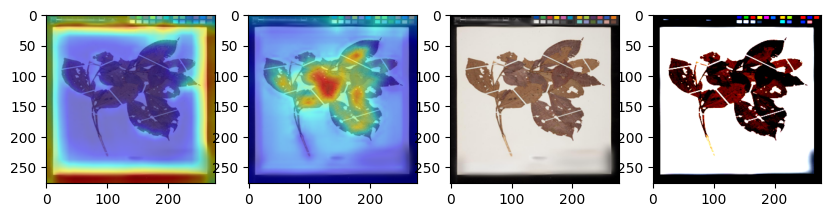

real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00000.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9999648332595825
Leandra nianga (DC.) Cogn. 2.246643452963326e-05
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00001.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9905917048454285
Miconia racemosa (Aubl.) DC. 0.00781848095357418
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00002.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9358512163162231
Leandra nianga (DC.) Cogn. 0.034958984702825546
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00003.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) T

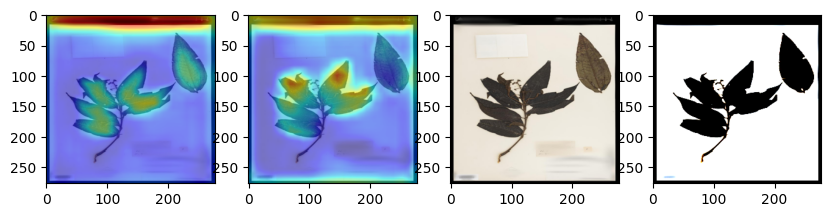

real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00005.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9362131953239441
Leandra nianga (DC.) Cogn. 0.053595900535583496
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00006.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.995049774646759
Miconia racemosa (Aubl.) DC. 0.004517980385571718
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00007.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9910854697227478
Miconia racemosa (Aubl.) DC. 0.00733181182295084
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00008.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) T

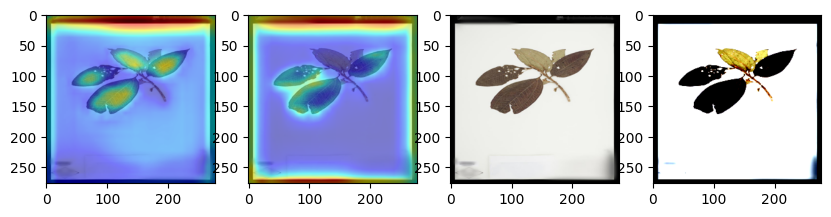

real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00010.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.7610051035881042
Miconia racemosa (Aubl.) DC. 0.20572619140148163
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00011.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9203023910522461
Miconia racemosa (Aubl.) DC. 0.06961752474308014
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00012.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9999507665634155
Leandra nianga (DC.) Cogn. 4.713550515589304e-05
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00013.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) 

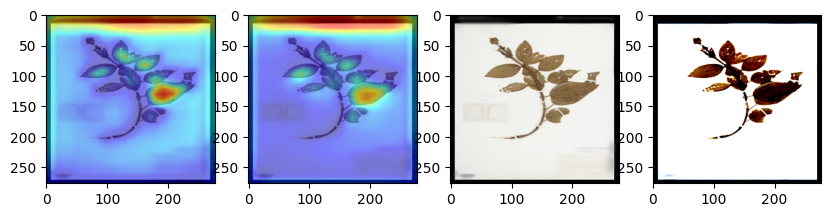

real class name:  Leandra nianga (DC.) Cogn.
image 00001.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.8467771410942078
Miconia ibaguensis (Bonpl.) Triana 0.1497112661600113
--------------------------------


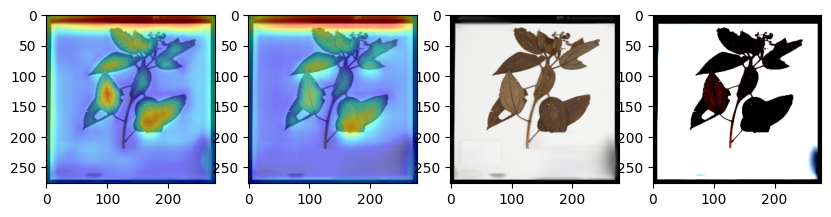

real class name:  Tibouchina semidecandra Cogn.
image 00000.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.6415572166442871
Miconia ibaguensis (Bonpl.) Triana 0.35778048634529114
--------------------------------


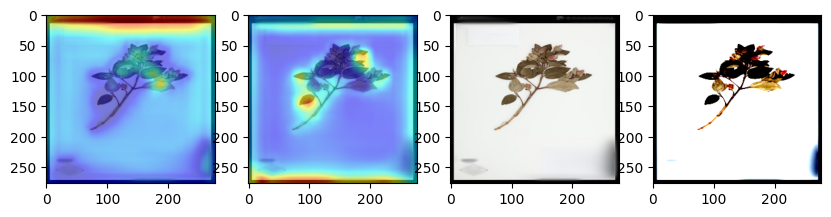

real class name:  Tibouchina semidecandra Cogn.
image 00001.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9493260979652405
Miconia racemosa (Aubl.) DC. 0.036680132150650024
--------------------------------


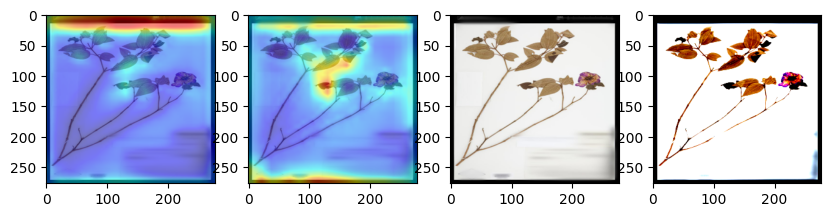

real class name:  Miconia racemosa (Aubl.) DC.
image 00000.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.5692234039306641
Miconia racemosa (Aubl.) DC. 0.37829819321632385
--------------------------------


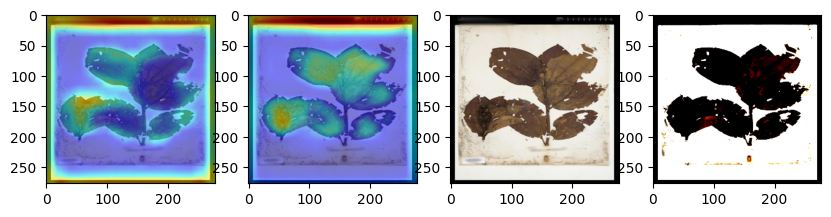

real class name:  Miconia racemosa (Aubl.) DC.
image 00001.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9832419157028198
Leandra nianga (DC.) Cogn. 0.01418854109942913
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00002.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.7553417086601257
Leandra nianga (DC.) Cogn. 0.14951010048389435
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00003.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.8980129957199097
Miconia ibaguensis (Bonpl.) Triana 0.10078443586826324
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00004.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.948922872543335
Miconia ibaguensis (Bonpl.) Triana 0.04406506

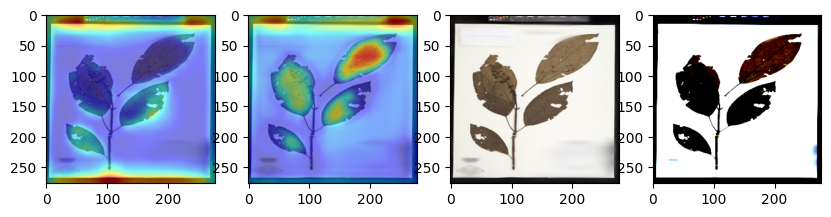

real class name:  Miconia racemosa (Aubl.) DC.
image 00006.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9445651173591614
Leandra nianga (DC.) Cogn. 0.0416770800948143
--------------------------------


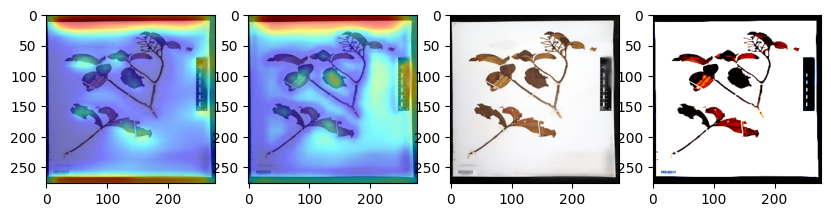

real class name:  Miconia racemosa (Aubl.) DC.
image 00007.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9493560791015625
Miconia ibaguensis (Bonpl.) Triana 0.02741156704723835
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00008.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9935404658317566
Leandra nianga (DC.) Cogn. 0.004689434077590704
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00009.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9943271279335022
Leandra nianga (DC.) Cogn. 0.005462025757879019
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00010.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9878280162811279
Leandra nianga (DC.) Cogn. 0.0101598938927

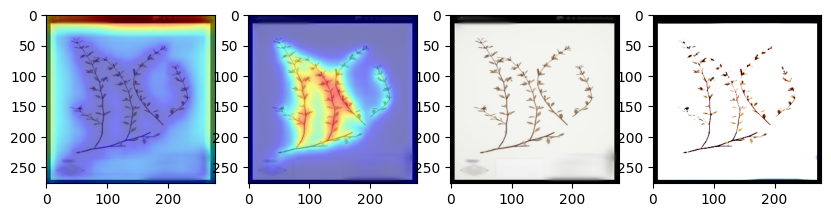

real class name:  Comolia lythrarioides Naudin
image 00001.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.5607654452323914
Leandra nianga (DC.) Cogn. 0.38059258460998535
--------------------------------


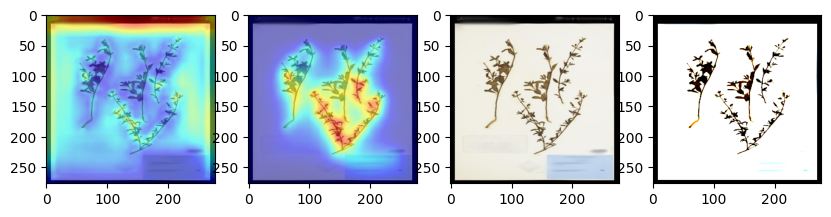

real class name:  Comolia lythrarioides Naudin
image 00002.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.5659637451171875
Miconia ibaguensis (Bonpl.) Triana 0.40625977516174316
--------------------------------


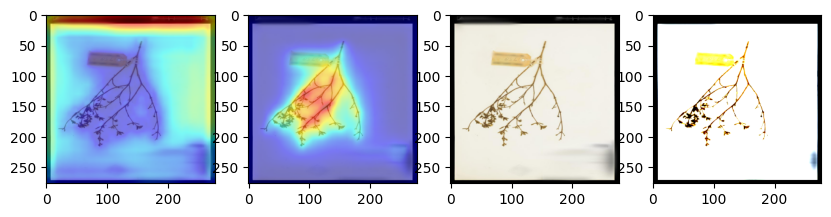

real class name:  Mouriri myrtilloides (Sw.) Poir.
image 00000.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.923625111579895
Leandra nianga (DC.) Cogn. 0.05599513649940491
--------------------------------


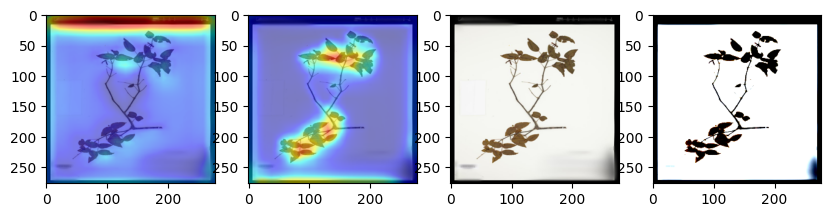

real class name:  Mouriri myrtilloides (Sw.) Poir.
image 00001.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9133971333503723
Mouriri myrtilloides (Sw.) Poir. 0.0792464092373848
--------------------------------


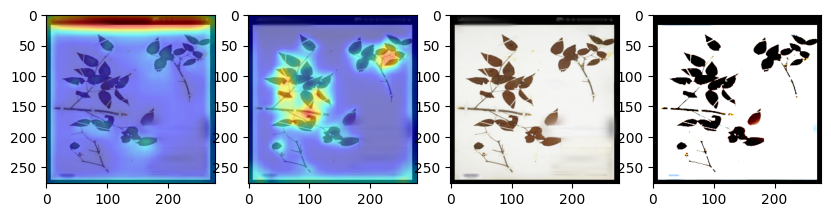

real class name:  Mouriri myrtilloides (Sw.) Poir.
image 00002.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9980167150497437
Leandra nianga (DC.) Cogn. 0.0014605728210881352
--------------------------------


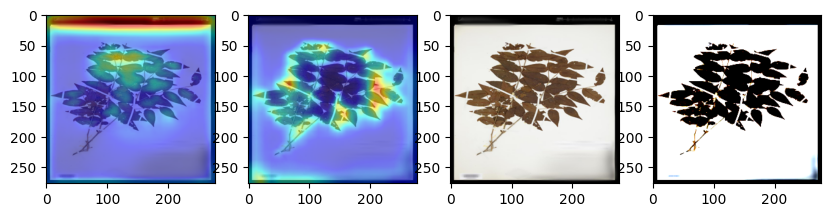

real class name:  Mouriri myrtilloides (Sw.) Poir.
image 00003.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9793382287025452
Leandra nianga (DC.) Cogn. 0.011234047822654247
--------------------------------


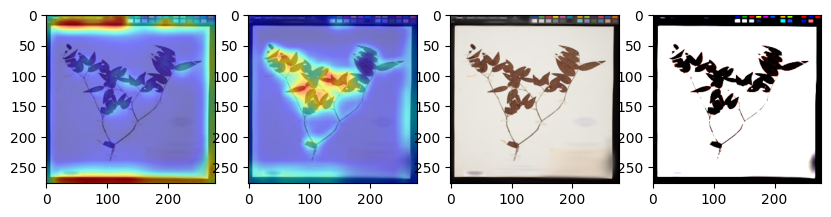

real class name:  Mouriri myrtilloides (Sw.) Poir.
image 00004.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.8462357521057129
Mouriri myrtilloides (Sw.) Poir. 0.10593842715024948
--------------------------------


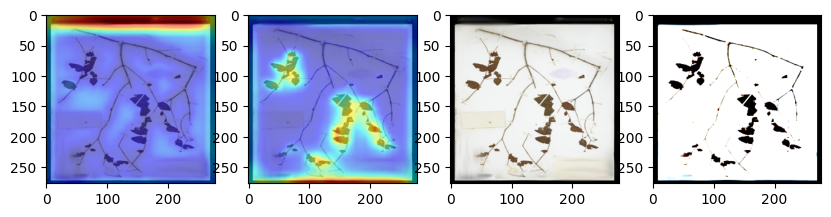

real class name:  Miconia corymbiformis Cogn.
image 00000.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9714564681053162
Miconia ibaguensis (Bonpl.) Triana 0.02573517896234989
--------------------------------


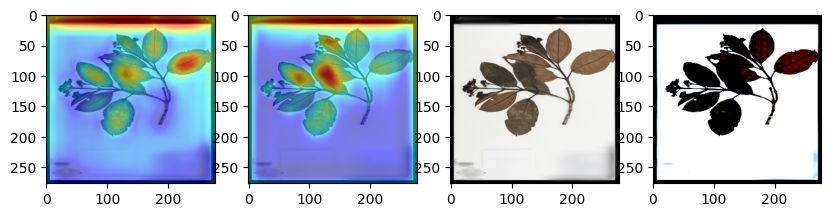

real class name:  Miconia corymbiformis Cogn.
image 00001.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.713627815246582
Miconia ibaguensis (Bonpl.) Triana 0.2832142114639282
--------------------------------


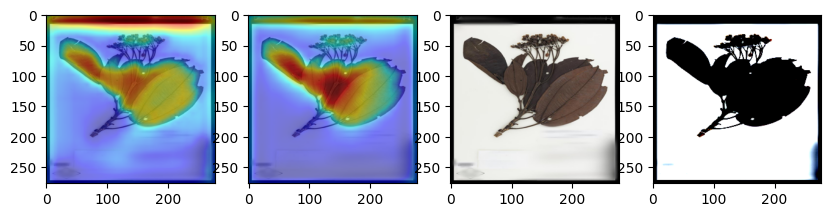

real class name:  Miconia corymbiformis Cogn.
image 00002.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.7666842937469482
Miconia racemosa (Aubl.) DC. 0.21703213453292847
--------------------------------


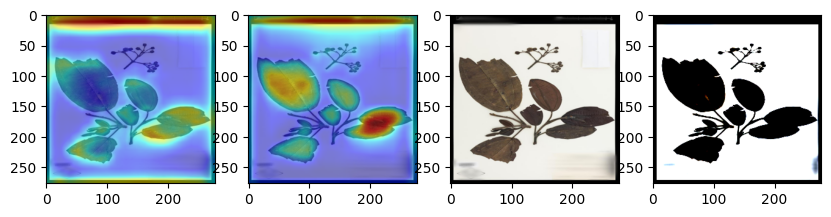

real class name:  Macairea parvifolia Benth.
image 00000.jpg Detecting for class Leandra nianga (DC.) Cogn. by model Res50
-
Leandra nianga (DC.) Cogn. 0.8396804928779602
Miconia racemosa (Aubl.) DC. 0.06506489962339401
--------------------------------


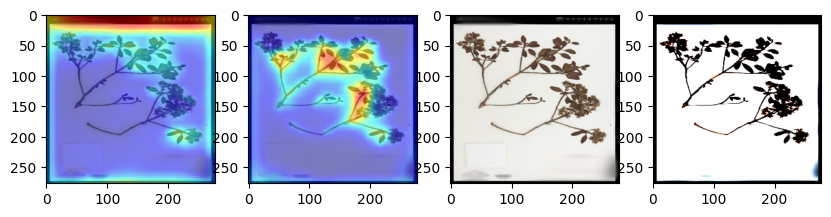

real class name:  Macairea parvifolia Benth.
image 00001.jpg Detecting for class Leandra nianga (DC.) Cogn. by model Res50
-
Leandra nianga (DC.) Cogn. 0.5957358479499817
Miconia racemosa (Aubl.) DC. 0.22978705167770386
--------------------------------


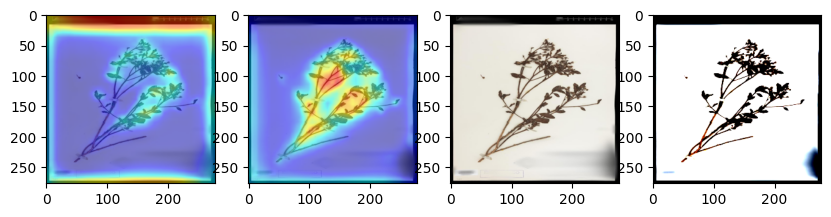

real class name:  Brachyotum strigosum (L.f.) Triana
image 00000.jpg Detecting for class Leandra nianga (DC.) Cogn. by model Res50
-
Leandra nianga (DC.) Cogn. 0.38512927293777466
Miconia ibaguensis (Bonpl.) Triana 0.34451791644096375
--------------------------------


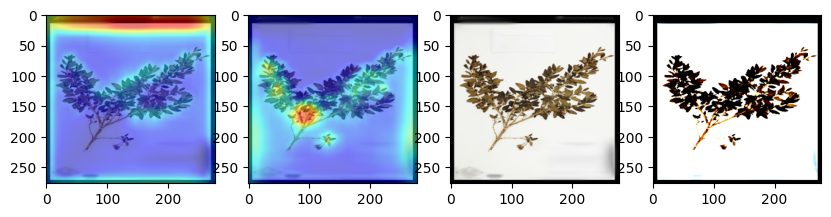

real class name:  Brachyotum strigosum (L.f.) Triana
image 00001.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.6429494023323059
Miconia racemosa (Aubl.) DC. 0.23894336819648743
--------------------------------


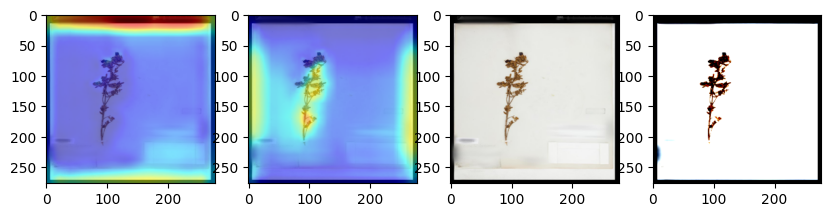

In [26]:
# Load the images
#/content/drive/MyDrive/Model Data/test-images


resize_size =(277,277)
#path = "cnn/saved_models/" +path
resize_to = transforms.Resize((277, 277))
#model.load_state_dict(torch.load(path))
model.eval()
directory = '/content/drive/MyDrive/Hebarium-Data-2019/Data/sample10/validation'

# use os.listdir() to get a list of all files in the directory
files = os.listdir(directory)
for filename in files:
  #print(filename)
  img_files = os.listdir('/content/drive/MyDrive/Hebarium-Data-2019/Data/sample/validation/'+filename)
  for img_file in img_files:
    #print(img_file)
    input_image = Image.open('/content/drive/MyDrive/Hebarium-Data-2019/Data/sample/validation/'+filename+"/"+img_file)
    preprocess = transforms.Compose(
          [
              resize_to,
              transforms.ToTensor(),
              transforms.Normalize(
                  mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
              ),  # IMPORTANT: normalize for pretrained models
          ]
    )
    input_tensor = preprocess(input_image)


    img_normalized = np.array(input_tensor)
    img_normalized = img_normalized.transpose(1, 2, 0)

    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

    #input_batch2 = torch.from_numpy(input_batch)
    
    #input_batch3 = input_batch2.numpy()

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
      input_batch = input_batch.to("cuda")
      model.to("cuda")

    with torch.no_grad():
        output = model(input_batch)

    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # print(probabilities)
    x , y = torch.topk(probabilities, 1) 
    #print(categories[y])
    print("real class name: ", foldername_to_class[str(filename)])
    print(f"image {img_file} Detecting for class {categories[y]} by model {modelname}")
    #print(f"Detecting for class {img_file + foldername_to_class[str(filename)} +  model {modelname}")
    print("-")
    # Show top categories per image

    top5_prob, top5_catid = torch.topk(probabilities, 2)
    #top1_prob, top1_catid = torch.topk(probabilities, )
    #print(categories[top1_catid[i]])
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print("--------------------------------")

    #print("this")
    if categories[y] != foldername_to_class[filename]:
      
      targets0 = [ClassifierOutputTarget(int(key_list[val_list.index(categories[y])]))] #0 for finch ?
      targets1 = [ClassifierOutputTarget(int(key_list[val_list.index(foldername_to_class[filename])]))]

      # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
      grayscale_cam0 = cam(input_batch, targets=targets0,aug_smooth=True)
      grayscale_cam1 = cam(input_batch, targets=targets1,aug_smooth=True)
      #print( "len grayscale_cam",len(grayscale_cam),grayscale_cam.shape)

      # In this example grayscale_cam has only one image in the batch:9
      grayscale_cam0 = grayscale_cam0[0, :]
      grayscale_cam1 = grayscale_cam1[0, :]


      img=np.array(input_image.resize(resize_size),np.float32)
      img = img.reshape(img.shape[1],img.shape[0],img.shape[2])
      #print("img shape",img.shape,img.max())
      img = img/255
      visualization0 = show_cam_on_image(img, grayscale_cam0, use_rgb=True)
      visualization1 = show_cam_on_image(img, grayscale_cam1, use_rgb=True)
      #cam_images = [show_cam_on_image(img, grayscale, use_rgb=True) for img, grayscale in zip(input_image, grayscale_cam)]
      visualization0 = Image.fromarray(visualization0)
      visualization1 = Image.fromarray(visualization1)
      #print("this")
      #out_file_name ="/content/drive/MyDrive/Herbarium Data-2019/Check2/" +modelname+ "_"+gradvariantname+ "_" + foldername_to_class[filename] + "_" +os.path.basename(filename)
      #print("this")




      fig, ax = plt.subplots(1, 4, figsize=(10, 4))

     # Set the aspect ratio of the images to 'equal'
      for i in range(3):
         ax[i].set_aspect('equal')

        # Plot the images on the subplots
      ax[0].imshow(visualization0, cmap='gray')
      ax[1].imshow(visualization1, cmap='gray')
      ax[2].imshow(input_image.resize(resize_size), cmap='gray')
      ax[3].imshow(img_normalized, cmap='gray')

      # Show the plot
      plt.show()









      # fig, ax = plt.subplots(1, 3)
      # ax[0].imshow(visualization0, cmap='gray')
      # ax[1].imshow(visualization1, cmap='gray')
      # ax[2].imshow(input_image.resize(resize_size), cmap='gray')
   



real class name:  Miconia approximata Gamba & Almeda
image 00000.jpg Detecting for class Miconia approximata Gamba & Almeda by model Res50
-
Miconia approximata Gamba & Almeda 0.964146614074707
Leandra nianga (DC.) Cogn. 0.020872769877314568
--------------------------------
real class name:  Miconia approximata Gamba & Almeda
image 00001.jpg Detecting for class Miconia approximata Gamba & Almeda by model Res50
-
Miconia approximata Gamba & Almeda 0.9579340219497681
Leandra nianga (DC.) Cogn. 0.033375002443790436
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00001.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9872053861618042
Leandra nianga (DC.) Cogn. 0.010655245743691921
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00004.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Tria

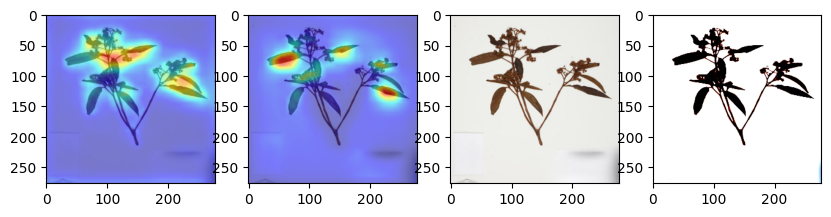

real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00002.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.4062013030052185
Miconia ibaguensis (Bonpl.) Triana 0.38132962584495544
--------------------------------


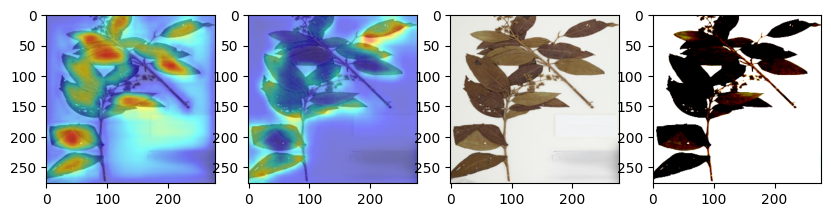

real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00010.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.8935614228248596
Miconia corymbiformis Cogn. 0.08040042966604233
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00009.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.68243408203125
Miconia racemosa (Aubl.) DC. 0.2929435670375824
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00013.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9808408617973328
Miconia racemosa (Aubl.) DC. 0.01774870976805687
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00014.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Tria

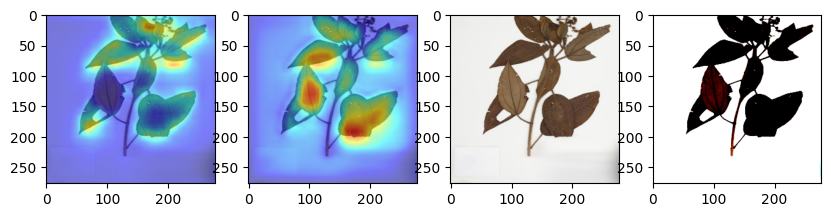

real class name:  Leandra nianga (DC.) Cogn.
image 00000.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.2811497151851654
Miconia ibaguensis (Bonpl.) Triana 0.27981308102607727
--------------------------------


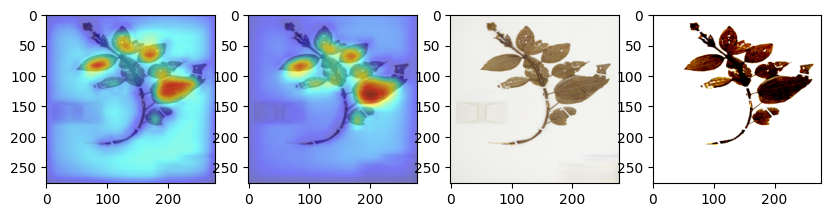

real class name:  Tibouchina semidecandra Cogn.
image 00000.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9361506104469299
Tibouchina semidecandra Cogn. 0.033686719834804535
--------------------------------


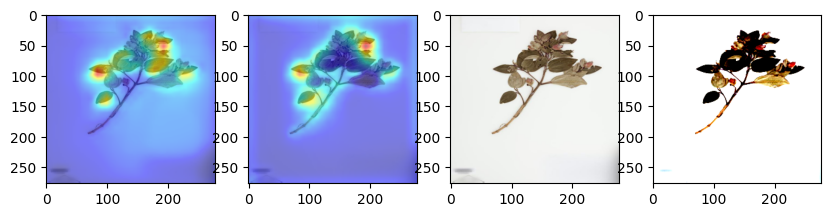

real class name:  Tibouchina semidecandra Cogn.
image 00001.jpg Detecting for class Brachyotum strigosum (L.f.) Triana by model Res50
-
Brachyotum strigosum (L.f.) Triana 0.44821733236312866
Tibouchina semidecandra Cogn. 0.2478676289319992
--------------------------------


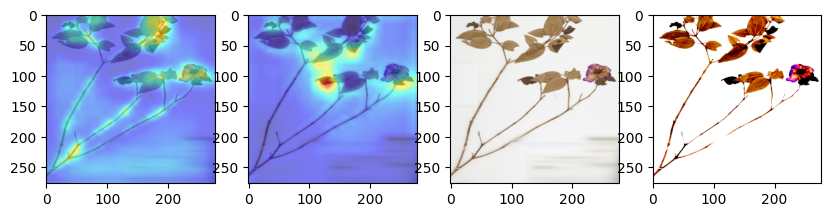

real class name:  Miconia racemosa (Aubl.) DC.
image 00001.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9976596832275391
Miconia ibaguensis (Bonpl.) Triana 0.0013879860052838922
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00000.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.6887266635894775
Leandra nianga (DC.) Cogn. 0.30343374609947205
--------------------------------


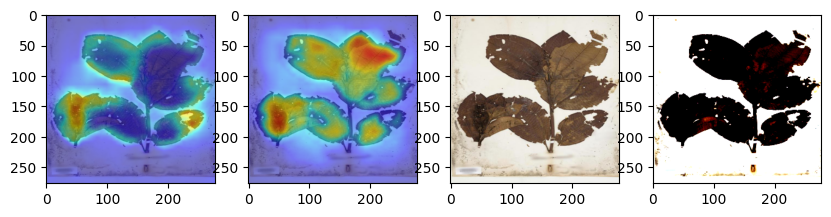

real class name:  Miconia racemosa (Aubl.) DC.
image 00002.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.43029505014419556
Miconia approximata Gamba & Almeda 0.303251713514328
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00004.jpg Detecting for class Miconia corymbiformis Cogn. by model Res50
-
Miconia corymbiformis Cogn. 0.9585679173469543
Miconia racemosa (Aubl.) DC. 0.027545254677534103
--------------------------------


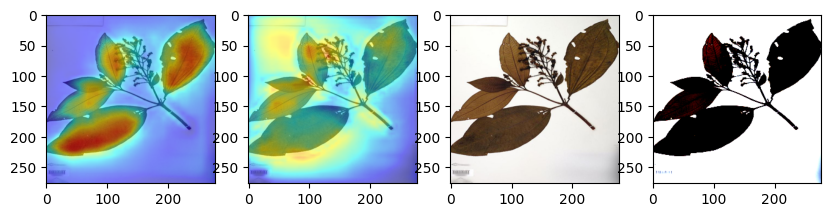

real class name:  Miconia racemosa (Aubl.) DC.
image 00003.jpg Detecting for class Miconia corymbiformis Cogn. by model Res50
-
Miconia corymbiformis Cogn. 0.5169861912727356
Miconia ibaguensis (Bonpl.) Triana 0.32908278703689575
--------------------------------


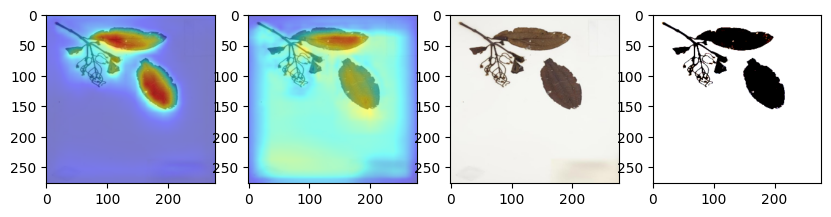

real class name:  Miconia racemosa (Aubl.) DC.
image 00005.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9527619481086731
Miconia ibaguensis (Bonpl.) Triana 0.02948884107172489
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00006.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9652710556983948
Miconia racemosa (Aubl.) DC. 0.019125694409012794
--------------------------------


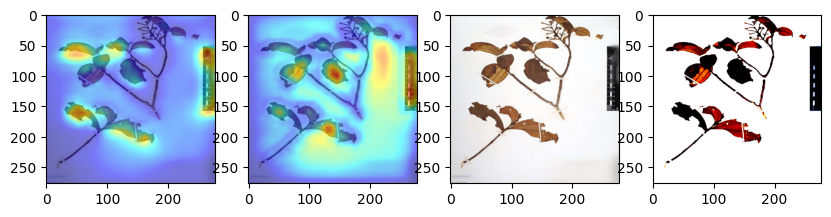

real class name:  Miconia racemosa (Aubl.) DC.
image 00007.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.7703738212585449
Miconia corymbiformis Cogn. 0.198163703083992
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00009.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9998260140419006
Miconia approximata Gamba & Almeda 9.620643686503172e-05
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00008.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.5964634418487549
Miconia ibaguensis (Bonpl.) Triana 0.3157523274421692
--------------------------------
real class name:  Miconia racemosa (Aubl.) DC.
image 00010.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.9589148163795471
Miconia corymbiformis Cogn. 0.031812

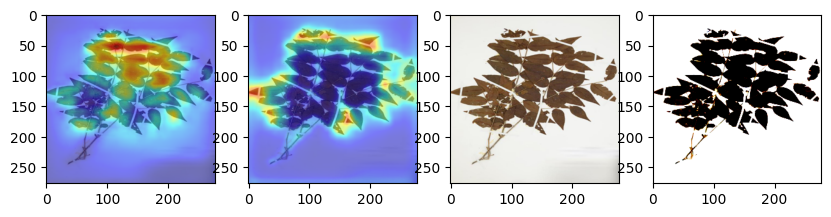

real class name:  Mouriri myrtilloides (Sw.) Poir.
image 00003.jpg Detecting for class Mouriri myrtilloides (Sw.) Poir. by model Res50
-
Mouriri myrtilloides (Sw.) Poir. 0.8431580662727356
Tibouchina semidecandra Cogn. 0.08391498774290085
--------------------------------
real class name:  Mouriri myrtilloides (Sw.) Poir.
image 00004.jpg Detecting for class Mouriri myrtilloides (Sw.) Poir. by model Res50
-
Mouriri myrtilloides (Sw.) Poir. 0.9905077219009399
Macairea parvifolia Benth. 0.008811093866825104
--------------------------------
real class name:  Miconia corymbiformis Cogn.
image 00000.jpg Detecting for class Miconia racemosa (Aubl.) DC. by model Res50
-
Miconia racemosa (Aubl.) DC. 0.7557758688926697
Miconia ibaguensis (Bonpl.) Triana 0.21328455209732056
--------------------------------


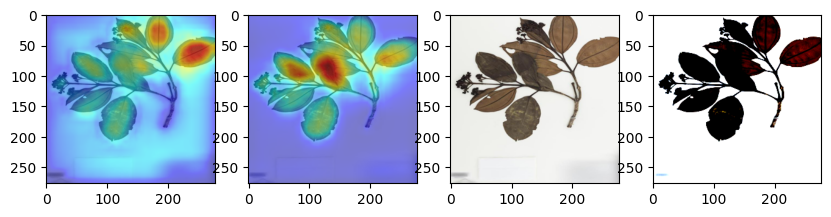

real class name:  Miconia corymbiformis Cogn.
image 00001.jpg Detecting for class Miconia corymbiformis Cogn. by model Res50
-
Miconia corymbiformis Cogn. 0.8559489846229553
Miconia ibaguensis (Bonpl.) Triana 0.12301374971866608
--------------------------------
real class name:  Miconia corymbiformis Cogn.
image 00002.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model Res50
-
Miconia ibaguensis (Bonpl.) Triana 0.9813671708106995
Leandra nianga (DC.) Cogn. 0.01019426342099905
--------------------------------


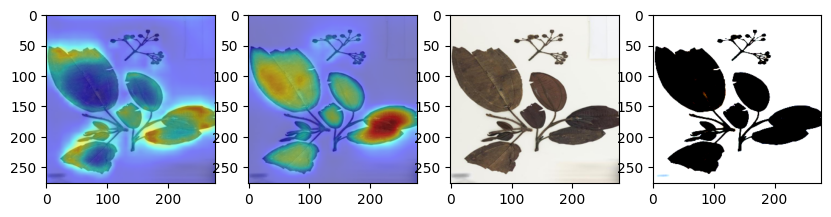

real class name:  Macairea parvifolia Benth.
image 00000.jpg Detecting for class Mouriri myrtilloides (Sw.) Poir. by model Res50
-
Mouriri myrtilloides (Sw.) Poir. 0.7014636993408203
Macairea parvifolia Benth. 0.2972496747970581
--------------------------------


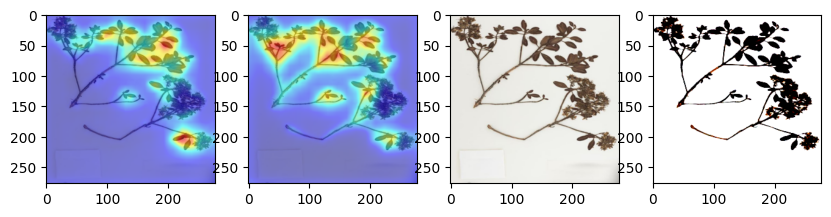

real class name:  Macairea parvifolia Benth.
image 00001.jpg Detecting for class Macairea parvifolia Benth. by model Res50
-
Macairea parvifolia Benth. 0.6388682723045349
Comolia lythrarioides Naudin 0.3583938181400299
--------------------------------
real class name:  Brachyotum strigosum (L.f.) Triana
image 00000.jpg Detecting for class Mouriri myrtilloides (Sw.) Poir. by model Res50
-
Mouriri myrtilloides (Sw.) Poir. 0.8817539811134338
Macairea parvifolia Benth. 0.09692706167697906
--------------------------------


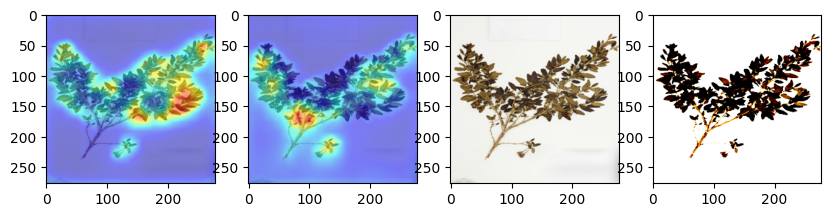

real class name:  Brachyotum strigosum (L.f.) Triana
image 00001.jpg Detecting for class Comolia lythrarioides Naudin by model Res50
-
Comolia lythrarioides Naudin 0.9775937795639038
Macairea parvifolia Benth. 0.014855080284178257
--------------------------------


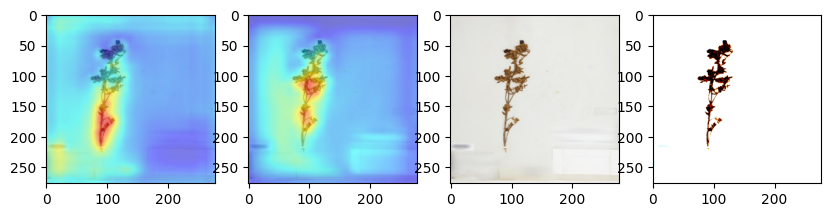

In [27]:
# Load the images
#/content/drive/MyDrive/Model Data/test-images


resize_size =(277,277)
#path = "cnn/saved_models/" +path
resize_to = transforms.Resize((277, 277))
#model.load_state_dict(torch.load(path))
model.eval()
directory = '/content/drive/MyDrive/Hebarium-Data-2019/Data/SampleBorder10/validation'

# use os.listdir() to get a list of all files in the directory
files = os.listdir(directory)
for filename in files:
  #print(filename)
  img_files = os.listdir('/content/drive/MyDrive/Hebarium-Data-2019/Data/SampleBorder10/validation/'+filename)
  for img_file in img_files:
    #print(img_file)
    input_image = Image.open('/content/drive/MyDrive/Hebarium-Data-2019/Data/SampleBorder10/validation/'+filename+"/"+img_file)
    preprocess = transforms.Compose(
          [
              resize_to,
              transforms.ToTensor(), 
              transforms.Normalize(
                  mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
              ),  # IMPORTANT: normalize for pretrained models
          ]
    )
    input_tensor = preprocess(input_image)


    img_normalized = np.array(input_tensor)
    img_normalized = img_normalized.transpose(1, 2, 0)

    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

    #input_batch2 = torch.from_numpy(input_batch)
    
    #input_batch3 = input_batch2.numpy()

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
      input_batch = input_batch.to("cuda")
      model.to("cuda")

    with torch.no_grad():
        output = model(input_batch)

    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # print(probabilities)
    x , y = torch.topk(probabilities, 1) 
    #print(categories[y])
    print("real class name: ", foldername_to_class[str(filename)])
    print(f"image {img_file} Detecting for class {categories[y]} by model {modelname}")
    #print(f"Detecting for class {img_file + foldername_to_class[str(filename)} +  model {modelname}")
    print("-")
    # Show top categories per image

    top5_prob, top5_catid = torch.topk(probabilities, 2)
    #top1_prob, top1_catid = torch.topk(probabilities, )
    #print(categories[top1_catid[i]])
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print("--------------------------------")

    #print("this")
    if categories[y] != foldername_to_class[filename]:
      
      targets0 = [ClassifierOutputTarget(int(key_list[val_list.index(categories[y])]))] #0 for finch ?
      targets1 = [ClassifierOutputTarget(int(key_list[val_list.index(foldername_to_class[filename])]))]

      # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
      grayscale_cam0 = cam(input_batch, targets=targets0,aug_smooth=True)
      grayscale_cam1 = cam(input_batch, targets=targets1,aug_smooth=True)
      #print( "len grayscale_cam",len(grayscale_cam),grayscale_cam.shape)

      # In this example grayscale_cam has only one image in the batch:9
      grayscale_cam0 = grayscale_cam0[0, :]
      grayscale_cam1 = grayscale_cam1[0, :]


      img=np.array(input_image.resize(resize_size),np.float32)
      img = img.reshape(img.shape[1],img.shape[0],img.shape[2])
      #print("img shape",img.shape,img.max())
      img = img/255
      visualization0 = show_cam_on_image(img, grayscale_cam0, use_rgb=True)
      visualization1 = show_cam_on_image(img, grayscale_cam1, use_rgb=True)
      #cam_images = [show_cam_on_image(img, grayscale, use_rgb=True) for img, grayscale in zip(input_image, grayscale_cam)]
      visualization0 = Image.fromarray(visualization0)
      visualization1 = Image.fromarray(visualization1)
      #print("this")
      #out_file_name ="/content/drive/MyDrive/Herbarium Data-2019/Check2/" +modelname+ "_"+gradvariantname+ "_" + foldername_to_class[filename] + "_" +os.path.basename(filename)
      #print("this")




      fig, ax = plt.subplots(1, 4, figsize=(10, 4))

     # Set the aspect ratio of the images to 'equal'
      for i in range(3):
         ax[i].set_aspect('equal')

        # Plot the images on the subplots
      ax[0].imshow(visualization0, cmap='gray')
      ax[1].imshow(visualization1, cmap='gray')
      ax[2].imshow(input_image.resize(resize_size), cmap='gray')
      ax[3].imshow(img_normalized, cmap='gray')

      # Show the plot
      plt.show()









      # fig, ax = plt.subplots(1, 3)
      # ax[0].imshow(visualization0, cmap='gray')
      # ax[1].imshow(visualization1, cmap='gray')
      # ax[2].imshow(input_image.resize(resize_size), cmap='gray')
   



Manipulating images:

1- GaussianBlur(radius=10)


In [38]:
from PIL import Image, ImageFilter
